# Collaborative filtering project

In this project, the task is to create a paper recommendation system. The system consists of 10,000 scientists and 1,000 papers. Scientists give ratings between 1–5 to the papers that they read. Since not all scientists have read every paper, we only have a limited amount of observations of these ratings. Additionally, each scientist has a wishlist of papers that they would like to read in the future. Your task is to fill in the missing observations using the provided rating and wishlist data, such that we can recommend papers to scientists that we expect them to rate highly.

More specifically, there are three data sources:
 - `train_tbr.csv` containing wishlist data.
 - `train_ratings.csv` containing observed rating data.
 - `sample_submission.csv` containing (scientist, paper) pairs that have to be rated for the evaluation of your method.

The data is available at `/cluster/courses/cil/collaborative_filtering/data` and an environment has been prepared for you at `/cluster/courses/cil/envs/collaborative_filtering`. You can activate the environment in your shell by running:
```bash
conda activate /cluster/courses/cil/envs/collaborative_filtering
```
If you wish to use notebooks on the cluster, you need to set the Environment path to `/cluster/courses/cil/envs/collaborative_filtering/bin` and load the `cuda/12.6` module.

**Evaluation**: Your models are evaluated using the root mean-squared error (RMSE) metric. Your grade is determined by a linear interpolation between the easy (grade 4) and hard (grade 6) baselines.

**Rules**: You are only allowed to use the data provided in `train_tbr.csv` and `train_ratings.csv` to make your predictions of `sample_submission.csv`. You are not allowed to use external data sources. But, you are allowed to use pre-trained models, as long as they are available publicly. Furthermore, no external API calls are allowed, except for downloading the weights of pre-trained models.

**We will verify your code for plagiarism and using solutions from previous years.**

[Link to Kaggle competition](https://www.kaggle.com/competitions/ethz-cil-collaborative-filtering-2025)


In [1]:
from typing import Tuple, Callable

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import os

Make sure that results are reproducible by using a seed.

In [2]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
class SVDpp(nn.Module):
    def __init__(self, num_scientists: int = 10000, num_papers: int = 10000, emb_dim: int = 32):
        super().__init__()

        # embeddings for scientists and papers
        self.scientist_factors = nn.Embedding(num_scientists, emb_dim)
        self.paper_factors = nn.Embedding(num_papers, emb_dim)
        self.scientist_bias = nn.Embedding(num_scientists, 1)
        self.paper_bias = nn.Embedding(num_papers, 1)

        # global average rating - TODO: maybe come up with smth better
        self.global_bias = nn.Parameter(torch.tensor([3.5]), requires_grad=False)

        # init weights - TODO: not tuned rn
        nn.init.normal_(self.scientist_factors.weight, std=0.1)
        nn.init.normal_(self.paper_factors.weight, std=0.1)
        nn.init.constant_(self.scientist_bias.weight, 0.0)
        nn.init.constant_(self.paper_bias.weight, 0.0)

    def forward(self, scientist_ids, paper_ids):
        # latent factors and biases for current batch
        scientist_embeddings = self.scientist_factors(scientist_ids)
        paper_embeddings = self.paper_factors(paper_ids)
        # squeeze to remove extra dim
        scientist_biases = self.scientist_bias(scientist_ids).squeeze()
        paper_biases = self.paper_bias(paper_ids).squeeze()
    
        # dot product for interaction
        interaction = (scientist_embeddings * paper_embeddings).sum(dim=1)
    
        # predict ratings
        predicted_ratings = interaction + scientist_biases + paper_biases + self.global_bias
        return predicted_ratings


## Helper functions

In [4]:
DATA_DIR = "/cluster/courses/cil/collaborative_filtering/data"


def read_data_df() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Reads in data and splits it into training and validation sets with a 75/25 split."""
    
    df = pd.read_csv(os.path.join(DATA_DIR, "train_ratings.csv"))

    # Split sid_pid into sid and pid columns
    df[["sid", "pid"]] = df["sid_pid"].str.split("_", expand=True)
    df = df.drop("sid_pid", axis=1)
    df["sid"] = df["sid"].astype(int)
    df["pid"] = df["pid"].astype(int)
    
    # Split into train and validation dataset
    train_df, valid_df = train_test_split(df, test_size=0.25)
    return train_df, valid_df


def read_data_matrix(df: pd.DataFrame) -> np.ndarray:
    """Returns matrix view of the training data, where columns are scientists (sid) and
    rows are papers (pid)."""

    return df.pivot(index="sid", columns="pid", values="rating").values


def evaluate(valid_df: pd.DataFrame, pred_fn: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> float:
    """
    Inputs:
        valid_df: Validation data, returned from read_data_df for example.
        pred_fn: Function that takes in arrays of sid and pid and outputs their rating predictions.

    Outputs: Validation RMSE
    """
    
    preds = pred_fn(valid_df["sid"].values, valid_df["pid"].values)
    return root_mean_squared_error(valid_df["rating"].values, preds)


def make_submission(pred_fn: Callable[[np.ndarray, np.ndarray], np.ndarray], filename: os.PathLike):
    """Makes a submission CSV file that can be submitted to kaggle.

    Inputs:
        pred_fn: Function that takes in arrays of sid and pid and outputs a score.
        filename: File to save the submission to.
    """
    
    df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

    # Get sids and pids
    sid_pid = df["sid_pid"].str.split("_", expand=True)
    sids = sid_pid[0]
    pids = sid_pid[1]
    sids = sids.astype(int).values
    pids = pids.astype(int).values
    
    df["rating"] = pred_fn(sids, pids)
    df.to_csv(filename, index=False)

## Singular value decomposition

For the first method in this introduction, we will make use of the singular value decomposition (SVD) to construct the optimal rank-$k$ approximation (when measuring the Frobenius norm as error), according to the Eckart-Young theorem. Since the matrix needs to be fully observed in order to make use of SVD, we need to impute the missing values. In this case, we impute values with $3$.

In [5]:
def impute_values(mat: np.ndarray) -> np.ndarray:
    return np.nan_to_num(mat, nan=3.0)

In [6]:
train_df, valid_df = read_data_df()
train_mat = read_data_matrix(train_df)
train_mat = impute_values(train_mat)

### Singular value spectrum

In order to assess which rank $k$ to use for the reconstruction matrix, we look at the spectrum of singular values and look for the "elbow". In this case, we will use $k=2$.

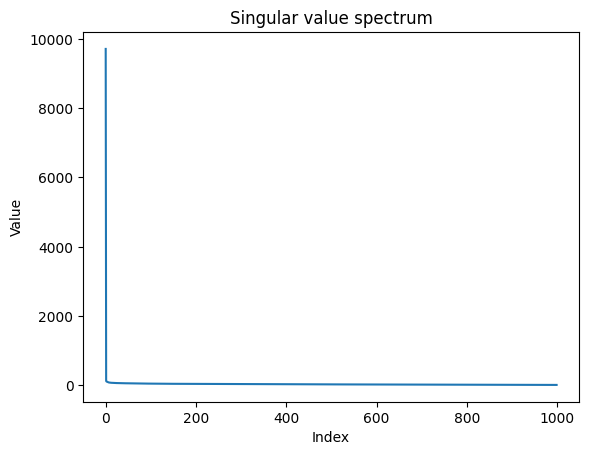

In [7]:
singular_values = np.linalg.svd(train_mat, compute_uv=False, hermitian=False)
plt.plot(singular_values)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Singular value spectrum")
plt.show()

In [8]:
def opt_rank_k_approximation(m: np.ndarray, k: int):
    """Returns the optimal rank-k reconstruction matrix, using SVD."""
    
    assert 0 < k <= np.min(m.shape), f"The rank must be in [0, min(m, n)]"
    
    U, S, Vh = np.linalg.svd(m, full_matrices=False)
    
    U_k = U[:, :k]
    S_k = S[:k]
    Vh_k = Vh[:k]
    
    return np.dot(U_k * S_k, Vh_k)


def matrix_pred_fn(train_recon: np.ndarray, sids: np.ndarray, pids: np.ndarray) -> np.ndarray:
    """
    Input:
        train_recon: (M, N) matrix with predicted values for every (sid, pid) pair.
        sids: (D,) vector with integer scientist IDs.
        pids: (D,) vector with integer paper IDs.
        
    Outputs: (D,) vector with predictions.
    """
    
    return train_recon[sids, pids]

We first obtain the optimal rank-$k$ approximation of the training matrix.

In [9]:
train_recon = opt_rank_k_approximation(train_mat, k=2)

Then, the values of this matrix reconstruction are the predictions for all (sid, pid)-pairs.

In [10]:
pred_fn = lambda sids, pids: matrix_pred_fn(train_recon, sids, pids)

# Evaluate on validation data
val_score = evaluate(valid_df, pred_fn)
print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 1.205


In [11]:
make_submission(pred_fn, "svd_submission.csv")

## Learned embeddings

Next, we will take a machine learning view of the problem. To each scientist and paper, we assign a $d$-dimensional embedding and we predict the rating that the scientist gives the paper to be their dot product. More formally, let $\vec{s}_i$ be a scientist embedding and $\vec{p}_j$ be a paper embedding. Then, we make the following rating prediction for this pair: $$\tilde{r}_{ij} = \langle \vec{s}_i, \vec{p}_j \rangle.$$ We view these embeddings as our learnable parameters and train them as we would any other model using the squared error loss function: $$\ell(\theta) = \frac{1}{2} |\langle \vec{s}_i, \vec{p}_j \rangle - r_{ij}|^2,$$ where $\theta = \{ \vec{s}_i \}_{i=1}^n \cup \{ \vec{p}_j \}_{j=1}^m$. The following is an implementation of this method.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


In [13]:
class EmbeddingDotProductModel(nn.Module):
    def __init__(self, num_scientists: int, num_papers: int, dim: int):
        super().__init__()

        # Assign to each scientist and paper an embedding
        self.scientist_emb = nn.Embedding(num_scientists, dim)
        self.paper_emb = nn.Embedding(num_papers, dim)
        
    def forward(self, sid: torch.Tensor, pid: torch.Tensor) -> torch.Tensor:
        """
        Inputs:
            sid: [B,], int
            pid: [B,], int
        
        Outputs: [B,], float
        """

        # Per-pair dot product
        return torch.sum(self.scientist_emb(sid) * self.paper_emb(pid), dim=-1)

Set $d=32$.

In [20]:
# Define model (10k scientists, 1k papers, 32-dimensional embeddings) and optimizer
#model = EmbeddingDotProductModel(10_000, 1_000, 32).to(device)
#optim = torch.optim.Adam(model.parameters(), lr=1e-3)

model = SVDpp().to(device)
optim = torch.optim.Adam(model.parameters(), lr=6e-4, weight_decay=3e-5) # global on = 
# optim = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=3e-5) # global on = 0856
# optim = torch.optim.Adam(model.parameters(), lr=6e-4, weight_decay=3e-5) + global off = 0.867
#optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)


In [21]:
def get_dataset(df: pd.DataFrame) -> torch.utils.data.Dataset:
    """Conversion from pandas data frame to torch dataset."""
    
    sids = torch.from_numpy(df["sid"].to_numpy())
    pids = torch.from_numpy(df["pid"].to_numpy())
    ratings = torch.from_numpy(df["rating"].to_numpy()).float()
    return torch.utils.data.TensorDataset(sids, pids, ratings)

In [22]:
train_dataset = get_dataset(train_df)
valid_dataset = get_dataset(valid_df)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

Training loop, which we run for 5 epochs.

In [ ]:
import copy

NUM_EPOCHS = 20 
best_rmse = float("inf")
patience = 2
epochs_no_improve = 0
best_model_state = None

for epoch in range(NUM_EPOCHS):
    # Train model for an epoch
    total_loss = 0.0
    total_data = 0
    model.train()
    for sid, pid, ratings in train_loader:
        sid = sid.to(device)
        pid = pid.to(device)
        ratings = ratings.to(device)

        pred = model(sid, pid)
        loss = F.mse_loss(pred, ratings)

        optim.zero_grad()
        loss.backward()
        optim.step()

        total_data += len(sid)
        total_loss += len(sid) * loss.item()

    # Evaluate on validation set
    total_val_mse = 0.0
    total_val_data = 0
    model.eval()
    for sid, pid, ratings in valid_loader:
        sid = sid.to(device)
        pid = pid.to(device)
        ratings = ratings.to(device)

        pred = model(sid, pid).clamp(1, 5)
        mse = F.mse_loss(pred, ratings)

        total_val_data += len(sid)
        total_val_mse += len(sid) * mse.item()

    val_rmse = (total_val_mse / total_val_data) ** 0.5
    train_loss = total_loss / total_data
    print(f"[Epoch {epoch+1}] Train loss={train_loss:.3f}, Valid RMSE={val_rmse:.3f}")

    # Early stopping check
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Stopped early at epoch {epoch+1}. Best RMSE: {best_rmse:.4f}")
        break

# load best model back
model.load_state_dict(best_model_state)


[Epoch 1] Train loss=0.906, Valid RMSE=0.900
[Epoch 2] Train loss=0.769, Valid RMSE=0.875
[Epoch 3] Train loss=0.720, Valid RMSE=0.865


In [18]:
pred_fn = lambda sids, pids: model(torch.from_numpy(sids).to(device), torch.from_numpy(pids).to(device)).clamp(1, 5).cpu().numpy()

# Evaluate on validation data
with torch.no_grad():
    val_score = evaluate(valid_df, pred_fn)

print(f"Validation RMSE: {val_score:.3f}")

Validation RMSE: 0.857


In [19]:
with torch.no_grad():
    make_submission(pred_fn, "learned_embedding_submission.csv")

## Outlook

To further improve the score, students can make use of the information in `train_tbr.csv`, which contains the papers that scientists want to read. Furthermore, students can look into more modern collaborative filtering methods and techniques.

Have fun :)